# Lab — Explainable GNN

Consider the GNNExplainer model — the method for explaining predictions made for GNNs.

In [1]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html -q
import dgl
dgl.__version__

'0.8.1'

In [2]:
import dgl
from dgl import utils
from dgl.data import CoraGraphDataset
from dgl.nn import GNNExplainer
from dgl.subgraph import node_subgraph
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from tqdm import tqdm
from dgl.base import NID, EID
from collections.abc import Mapping
import networkx as nx
import matplotlib.pyplot as plt


### CORA dataset

Let us download CORA dataset for the node classification task.

In [3]:
dataset = CoraGraphDataset()
graph = dataset[0]
graph

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})

In [4]:
labels = graph.ndata['label']
labels.shape

torch.Size([2708])

In [5]:
feat = graph.ndata['feat']
feat.shape

torch.Size([2708, 1433])

In [6]:
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']
val_mask = graph.ndata['val_mask']
train_mask


tensor([False, False, False,  ..., False, False, False])

### Target GNN model

Define a simple two-layer GCN.

In [7]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats=in_dim, out_feats=hid_dim, activation=nn.ReLU())
        self.conv2 = dgl.nn.GraphConv(in_feats=hid_dim, out_feats=out_dim)
    def forward(self, graph, feat, eweight=None):
        h = self.conv1(graph, feat, edge_weight=eweight)
        h = self.conv2(graph, h, edge_weight=eweight)
        return h

model = GCN(in_dim=1433, hid_dim=128, out_dim=7)

Train the model on the node classification task.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
model.train()
n_epochs = 200
for e in range(1, n_epochs+1):
    logits = model(graph, feat=feat)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e % 10 == 0:
        pred = logits.argmax(dim=1)
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        print(f'Epoch: {e}/{n_epochs}, Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

/opt/anaconda3/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 10/200, Train accuracy: 0.61, Validation accuracy: 0.36
Epoch: 20/200, Train accuracy: 0.77, Validation accuracy: 0.46
Epoch: 30/200, Train accuracy: 0.79, Validation accuracy: 0.48
Epoch: 40/200, Train accuracy: 0.84, Validation accuracy: 0.54
Epoch: 50/200, Train accuracy: 0.87, Validation accuracy: 0.56
Epoch: 60/200, Train accuracy: 0.88, Validation accuracy: 0.58
Epoch: 70/200, Train accuracy: 0.91, Validation accuracy: 0.60
Epoch: 80/200, Train accuracy: 0.91, Validation accuracy: 0.63
Epoch: 90/200, Train accuracy: 0.94, Validation accuracy: 0.65
Epoch: 100/200, Train accuracy: 0.94, Validation accuracy: 0.68
Epoch: 110/200, Train accuracy: 0.95, Validation accuracy: 0.70
Epoch: 120/200, Train accuracy: 0.95, Validation accuracy: 0.71
Epoch: 130/200, Train accuracy: 0.95, Validation accuracy: 0.72
Epoch: 140/200, Train accuracy: 0.95, Validation accuracy: 0.73
Epoch: 150/200, Train accuracy: 0.95, Validation accuracy: 0.73
Epoch: 160/200, Train accuracy: 0.96, Validation 

### K-hop computatinal subgraphs

Let the target node be 1010. To explain the prediction for the target node, we consider its k-hop neighbors. 

In [9]:
test_mask[1010]

tensor(True)

First, consider the 1-hop computational subgraph, that is a set of direct neighbors of the target node.

In [10]:
target_node = 1010
sg, _ = dgl.khop_in_subgraph(graph, nodes=target_node, k=1, relabel_nodes=True)

The initail node ids are stored in node features.

In [11]:
sg.nodes()

tensor([0, 1, 2, 3, 4, 5, 6])

In [12]:
sg.ndata[NID]

tensor([ 507,  508,  509,  944, 1010, 1012, 1800])

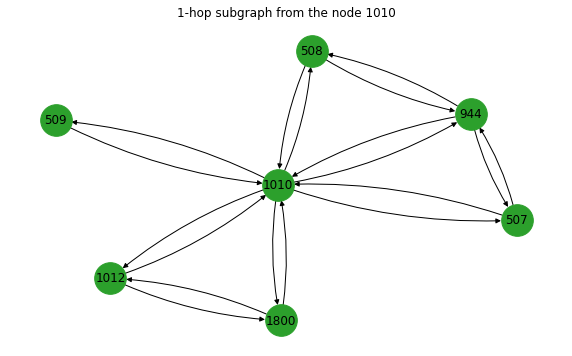

In [13]:
plt.figure(figsize=(10, 6))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
nx.draw_networkx(
    sg.to_networkx(), 
    pos = nx.kamada_kawai_layout(sg.to_networkx()),
    node_size=1000,
    labels=node_ids, 
    connectionstyle='arc3, rad=0.1',
    node_color='tab:green'
)
plt.axis('off')
plt.title(f'1-hop subgraph from the node {target_node}')
plt.show()

Next, consider the 2-hop computational graph, that is a set of 2-hop neighbors of the target node.

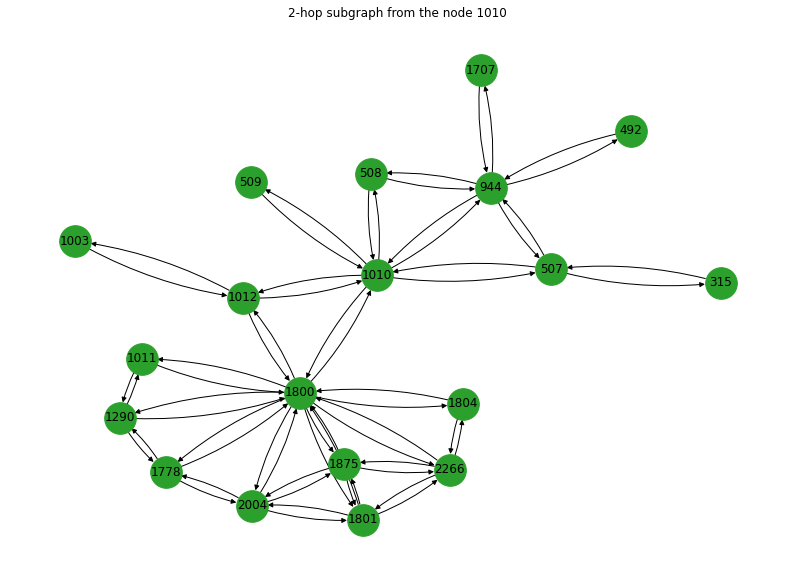

In [14]:
sg, _ = dgl.khop_in_subgraph(graph, nodes=target_node, k=2, relabel_nodes=True)
plt.figure(figsize=(14, 10))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
nx.draw_networkx(
    sg.to_networkx(), 
    pos = nx.kamada_kawai_layout(sg.to_networkx()),
    node_size=1000,
    labels=node_ids, 
    connectionstyle='arc3, rad=0.1',
    node_color='tab:green'
)
plt.axis('off')
plt.title(f'2-hop subgraph from the node {target_node}')
plt.show()

### GNNExplainer

Given a trained GNN model $Φ$ and a prediction or a set of predictions, the GNNExplainer will generate an explanation by identifying a subgraph $G_S$ of the computation graph and a binary mask $F$ over node features $X_S$ that are most influential for the model $Φ$’s prediction.

Formulate the GNNExplainer as the maximization of mutual information between predicted label distribution $Y$ and explanation $(G_{S}, F)$:

$$\max _{G_S, F} \text{MI}\left(Y, \left(G_{S}, F\right)\right)=H(Y)-H\left(Y \mid G=G_{S}, X=X_{S}^F\right)$$

which is equivalent to minimizing the conditional entropy $H(Y |G = G_S, X = X_S^F)$ that can be expressed as

$$ \min _{G_S, F} H(Y |G = G_S, X = X_S^F) = −\mathbb E_{Y |G_S ,X_S^F} [\log P_Ф(Y |G=G_S, X =X_S^F)] $$

Create an explainer object.

In [15]:
explainer = GNNExplainer(model, num_hops=1, lr=0.005, num_epochs=300, log=True)

Explainer returns a new ID of the target node, computational subgraph, feature importance, edge importance.

In [16]:
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=feat
)

Explain node {node_id}: 100%|██████████| 300/300 [00:01<00:00, 182.87it/s]


In [17]:
print(new_node_id)
print(sg)
print(feat_mask)
print(edge_mask)

tensor([4])
Graph(num_nodes=7, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([0.1946, 0.1980, 0.2280,  ..., 0.1909, 0.1967, 0.2160])
tensor([0.8838, 0.7850, 0.1065, 0.7871, 0.7953, 0.8868, 0.8885, 0.8392, 0.9005,
        0.9028, 0.1194, 0.1073, 0.9122, 0.8987, 0.8752, 0.8728, 0.8369, 0.8010])


Plot a 1-hop subgraph where edges are colored by their importance to the predicted class of the target node.

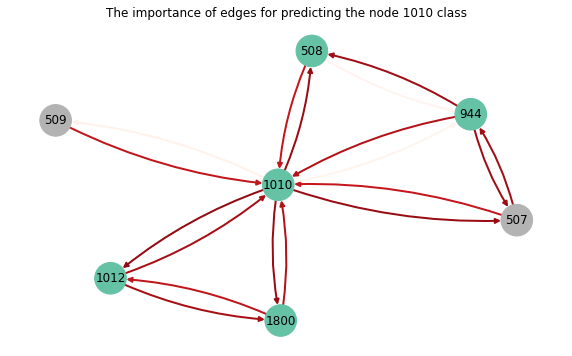

In [18]:
plt.figure(figsize=(10, 6))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
G = sg.to_networkx()
color = sg.ndata['label']
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G, pos=pos, node_size=1000, node_color=color, cmap=plt.cm.Set2
)
nx.draw_networkx_labels(G, pos=pos, labels=node_ids)
nx.draw_networkx_edges(
    G, pos=pos, node_size=1000, width=2,
    edge_color=edge_mask.numpy(), 
    edge_cmap=plt.cm.Reds,
    edge_vmin=0.1, edge_vmax=0.99,
    connectionstyle='arc3, rad=0.1',
)
plt.axis('off')
plt.title(f'The importance of edges for predicting the node {target_node} class')
plt.show()

Next, let us look at 2-hop subgraph explanations.

In [19]:
explainer = GNNExplainer(model, num_hops=2, lr=0.005, num_epochs=300, log=True)
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=feat
)

Explain node {node_id}: 100%|██████████| 300/300 [00:01<00:00, 177.34it/s]


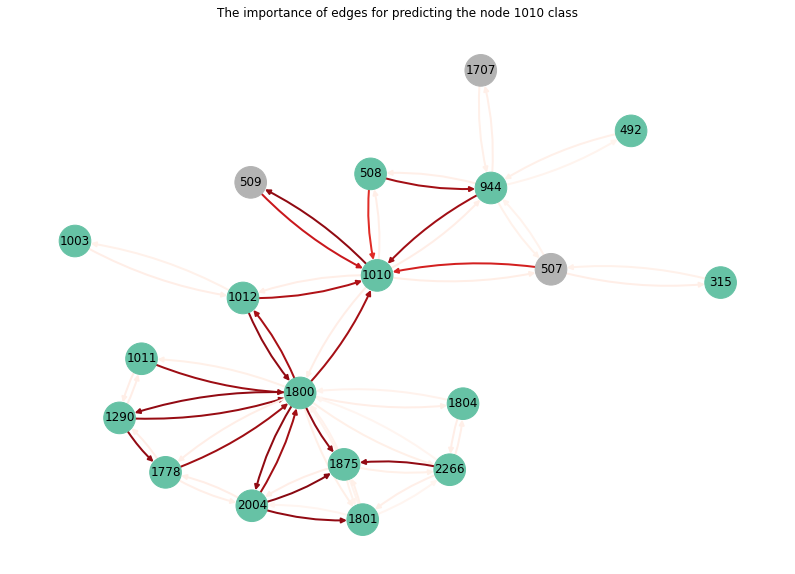

In [20]:
plt.figure(figsize=(14, 10))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
G = sg.to_networkx()
color = sg.ndata['label']
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G, pos=pos, node_size=1000, node_color=color, cmap=plt.cm.Set2
)
nx.draw_networkx_labels(G, pos=pos, labels=node_ids)
nx.draw_networkx_edges(
    G, pos=pos, node_size=1000, width=2,
    edge_color=edge_mask.numpy(), 
    edge_cmap=plt.cm.Reds,
    edge_vmin=0.1, edge_vmax=0.99,
    connectionstyle='arc3, rad=0.1',
)
plt.axis('off')
plt.title(f'The importance of edges for predicting the node {target_node} class')
plt.show()

Since our target model is 2 layer GCN, the 2-hop computational graph is more representative. Let us look at the feature importance.

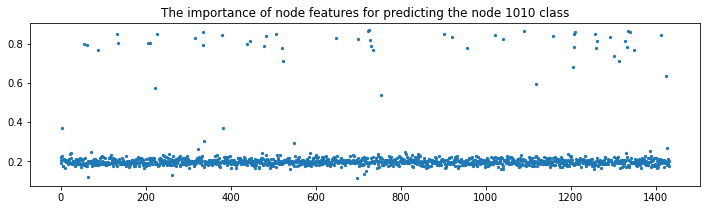

In [21]:
plt.figure(figsize=(12, 3))
plt.scatter(range(1433), feat_mask, s=5)
plt.title(f'The importance of node features for predicting the node {target_node} class')
plt.show()

Let us add the label into train set and check that the importance of such attributes be large.

In [22]:
graph.ndata['feat'].shape

torch.Size([2708, 1433])

In [23]:
F.one_hot(graph.ndata['label']).shape

torch.Size([2708, 7])

Concatenate the last 100 features and new 7-dimensional label matrix.

In [24]:
_feat = torch.cat([graph.ndata['feat'][:, -100:], F.one_hot(graph.ndata['label'])], dim=1)
_feat.shape

torch.Size([2708, 107])

In [25]:
model = GCN(in_dim=107, hid_dim=128, out_dim=7)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
model.train()
n_epochs = 500
for e in range(1, n_epochs+1):
    logits = model(graph, feat=_feat)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e % 50 == 0:
        pred = logits.argmax(dim=1)
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        print(f'Epoch: {e}/{n_epochs}, Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

Epoch: 50/500, Train accuracy: 0.98, Validation accuracy: 0.95
Epoch: 100/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 150/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 200/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 250/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 300/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 350/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 400/500, Train accuracy: 1.00, Validation accuracy: 0.94
Epoch: 450/500, Train accuracy: 1.00, Validation accuracy: 0.94
Epoch: 500/500, Train accuracy: 1.00, Validation accuracy: 0.94
Test accuracy: 0.93


In [27]:
explainer = GNNExplainer(model, num_hops=2, lr=0.005, num_epochs=300, log=True)
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=_feat
)

Explain node {node_id}: 100%|██████████| 300/300 [00:01<00:00, 157.59it/s]


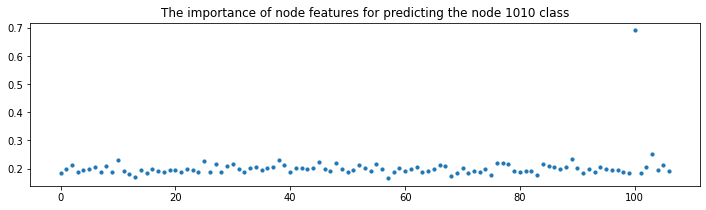

In [28]:
plt.figure(figsize=(12, 3))
plt.scatter(range(107), feat_mask, s=10)
plt.title(f'The importance of node features for predicting the node {target_node} class')
plt.show()

As we see, the true label 0 corresponds to the most important 100th attribute.